In [1]:
import spotipy
from spotipy import SpotifyClientCredentials
import sys
sys.path.append('src')
import numpy as np
import mosaic_maker
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse

In [2]:
import toml

client_info = toml.load('spotify_user_details.toml')

In [3]:
CLIENT_ID = client_info['SpotifyUser']['CLIENT_ID']
CLIENT_SECRET = client_info['SpotifyUser']['CLIENT_SECRET']

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,
                                                           client_secret=CLIENT_SECRET))
mm = mosaic_maker.MosaicMaker(sp)

In [4]:
a = mosaic_maker.Album('meshuggah', 'chaosphere')
mm.query_album(a)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 datetime.datetime(1998, 12, 29, 0, 0))

In [5]:
mm.get_albums('src/album_list.csv')

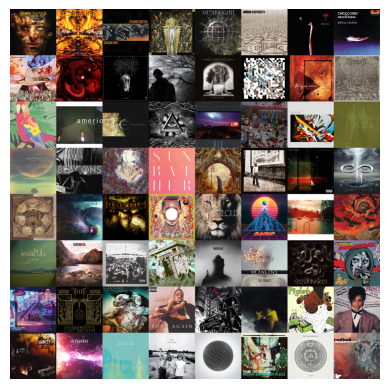

In [6]:
mosaic = mm.create_mosaic()
plt.figure()
plt.imshow(mosaic)
plt.axis(False)
plt.show()

sorting by color


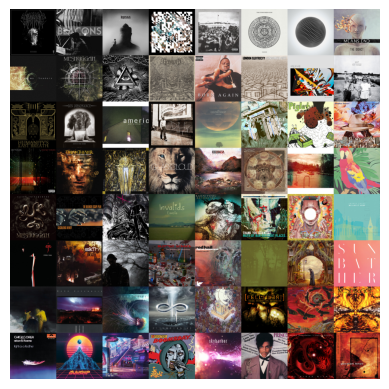

In [17]:
np.random.shuffle(mm.album_list)
mm.sort_album_list(method='color')
mosaic = mm.create_mosaic()
plt.figure()
plt.imshow(mosaic)
plt.axis(False)
plt.savefig('example.png')
plt.show()

sorting by date


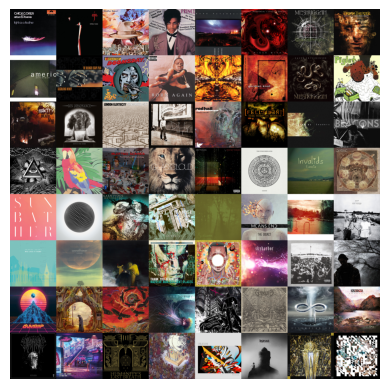

In [15]:
mm.sort_album_list(method='date')
mosaic = mm.create_mosaic()
plt.figure()
plt.imshow(mosaic)
plt.axis(False)
plt.show()

In [9]:
import joblib

joblib.dump(mosaic, 'mosaic.pkl')

['mosaic.pkl']

# Analysing Mosaic

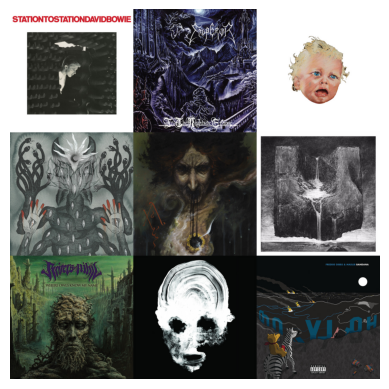

In [10]:
import joblib
import matplotlib.pyplot as plt

mosaic = joblib.load('mosaic.pkl')
plt.figure()
plt.imshow(mosaic)
plt.axis(False)
plt.show()

In [11]:
import PIL
from PIL.Image import Resampling
import cv2

all_art = []
for i in range(len(mm.album_list)):
    cover = mm.album_list[i].artwork.resize((3, 3), Resampling.BICUBIC)
    #cover = cover.convert('HSV')
    cover = cv2.cvtColor(np.array(cover), cv2.COLOR_RGB2LAB)
    cover = np.ravel(cover)
    all_art += [cover]

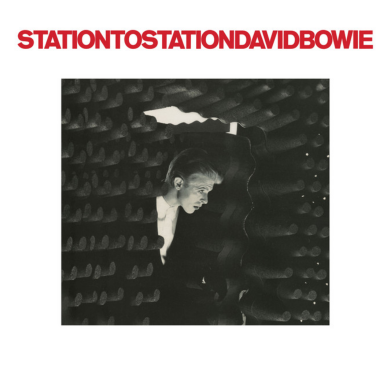

In [12]:
plt.figure()
plt.imshow(mm.album_list[0].artwork)
plt.axis(False)
plt.show()


# Project onto Rainbow

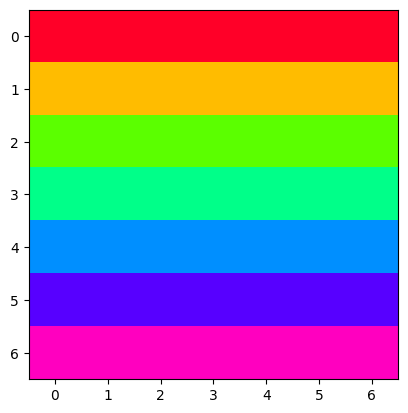

In [ ]:
import matplotlib

rainbow_im = np.zeros((7, 7, 3))

cm = matplotlib.cm.get_cmap('gist_rainbow', 7)
for i in range(7):
    for j in range(7):
        rainbow_im[i,j,:] = cm(i)[0:3]

plt.figure()
plt.imshow(rainbow_im)
plt.show()

# Dimension Reduction and Clustering Images

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

### Feature Extraction

In [ ]:
all_feat = []
for im in mm.album_list:
    # Convert to HSV
    img = np.array(im.artwork.resize((64, 64), PIL.Image.Resampling.BICUBIC))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    feat_vec = np.mean(np.mean(img, axis=0), axis=0)
    all_feat += [feat_vec]
all_feat = np.array(all_feat)

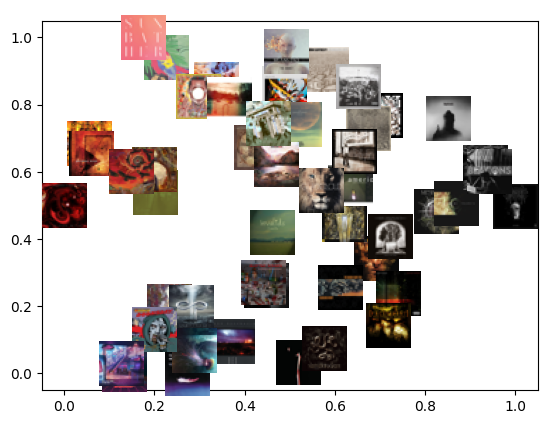

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

all_feat_norm = MinMaxScaler().fit_transform(all_feat)
#embedding = PCA(n_components=2).fit_transform(all_feat_norm)
embedding = TSNE(n_components=2).fit_transform(all_feat_norm)
embedding = MinMaxScaler().fit_transform(embedding)

plt.figure()
for i in range(49):
    x = embedding[i, 0]
    y = embedding[i, 1]
    imscatter(x, y, np.array(mm.album_list[i].artwork.resize((32, 32))))
plt.show()

In [ ]:
# https://github.com/kylemcdonald/CloudToGrid/blob/master/CloudToGrid.ipynb
side = 7 

xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)

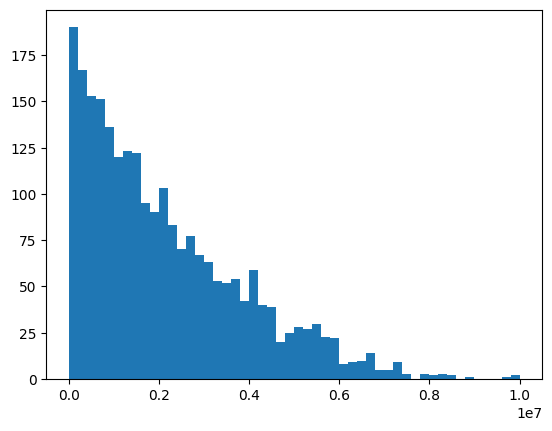

In [ ]:
from scipy.spatial.distance import cdist
cost = cdist(grid, embedding, 'sqeuclidean')
cost = cost * (10000000. / cost.max())

plt.figure()
plt.hist(cost.ravel(), bins=50)
plt.show()

In [ ]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost, maximize=False)

In [ ]:
import lapjv

row_ind, col_ind, _ = lapjv.lapjv(cost)

In [ ]:
grid_hu = grid[col_ind]

In [ ]:
ind = np.lexsort((grid_hu[:, 1], grid_hu[:, 0]))
mm.album_list = np.array(mm.album_list)[ind]
mosaic = mm.create_mosaic()

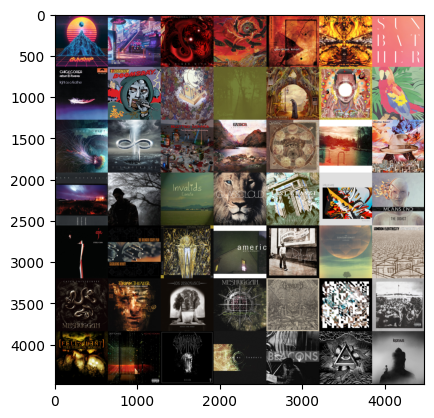

In [ ]:
plt.figure()
plt.imshow(mosaic)
plt.show()

In [ ]:
k = 0
plt.figure(figsize=(8, 8))
for start, end in zip(embedding, grid_hu):
    #plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
    #          head_length=0.01, head_width=0.01)
    imscatter(end[1], end[0], np.array(mm.album_list[k].artwork.resize((64, 64))))
    k += 1
plt.axis(False)
plt.show()

In [ ]:
side = 45
totalDataPoints = side * side
data3d = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints, 3))

tsne = TSNE(n_components=2, learning_rate=50)
data2d = tsne.fit_transform(data3d)

In [ ]:
data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(data2d[:,0], data2d[:,1], c=data3d, edgecolors='none', marker='o', s=12)  
plt.show()

In [ ]:
xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)

cost = cdist(grid, data2d, 'sqeuclidean')
cost = cost * (10000000. / cost.max())

row_assigns,col_assigns = linear_sum_assignment(cost, maximize=False)
grid_hu = grid[col_assigns]
plt.figure(figsize=(8, 8))
for start, end in zip(data2d, grid_hu):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
    #plt.scatter(data2d[end[0],0], data2d[end[1],1], c=data3d, edgecolors='none', marker='o', s=12)  
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(grid_hu[:,0], grid_hu[:,1], c=data3d, edgecolors='none', marker='o', s=36)  
plt.show()

In [ ]:
import lapjv

row_ind, col_ind, _ = lapjv.lapjv(cost)

In [ ]:
grid_jv = grid[col_ind]

plt.figure(figsize=(8, 8))
plt.scatter(grid_jv[:,0], grid_jv[:,1], c=data3d, edgecolors='none', marker='o', s=36)  
plt.show()

### Apply Rasterfairy

In [ ]:
import rasterfairy

grid_xy = rasterfairy.transformPointCloud2D(embedding)


In [ ]:
new_inds = np.digitize(embedding[:, :]*7, np.arange(0, 7))-1
image_mat = np.zeros((7, 7), dtype=int)

print(new_inds)

for i, m in enumerate(new_inds):
    image_mat[m[1], m[0]] = i

# Iterate out like a puddle

In [ ]:
from sklearn.neighbors import KDTree

album_inds = np.arange(0, 49)
embedding2 = embedding

for i in range(49):
    kd = KDTree(embedding)
    k = 49
    dist, ind = kd.query(embedding2[0, :].reshape(1, -1), k=k)

np.pad(ind[0, :4].reshape((2, 2)), (0, 5))

In [ ]:
plt.figure()
for i in range(k):
    plt.subplot(1, k, i+1)
    plt.imshow(mm.album_list[ind[0][i]].artwork)
    plt.axis(False)
plt.show()

In [ ]:
np.pad(ind[m].reshape((2, 2)), (0, 5))

In [ ]:
image_mat = np.zeros((7, 7), dtype=np.int64)
m = 0
for i in range(7):
    for j in range(7):
        if i == 0 and j == 0:
            image_mat = image_mat + np.pad(ind[m].reshape((2, 2)), (0, 5))
        else:
            m = image_mat[i, j]
            image_mat = image_mat * np.pad(np.zeros((2, 2)), ((0, 5), (0+j, 5-j)), 'constant', constant_values=(1)) # Reset area
            image_mat = image_mat + np.pad(ind[m].reshape((2, 2)), ((0, 5), (0+j, 5-j)))
            break
    break

print(image_mat)

In [ ]:
image_mat

In [ ]:
np.pad(np.zeros((2, 2)), ((0, 5), (0+j, 5-j)), 'constant', constant_values=(1))

In [ ]:
np.pad(ind[m].reshape((2, 2)), ((0, 5), (1, 4)))

In [ ]:
mosaic_ind = np.zeros((7, 7), dtype=int)
im_ind_array = np.arange(0, 49)

img_ind = np.random.choice(im_ind_array) # initial img ind
im_ind_array = np.delete(im_ind_array, np.where(im_ind_array == img_ind))
print(img_ind)

for i in range(7):
    for j in range(7):
        dist, ind = kd.query(embedding[img_ind, :].reshape(1, -1), k = 4)
        mosaic_ind[i, j] = ind[0][0]
        mosaic_ind[i+1, j] = ind[0][1]
        mosaic_ind[i, j+1] = ind[0][2]
        mosaic_ind[i+1, j+1] = ind[0][3]
        img_ind = ind[0][1]

mosaic_ind

In [ ]:
mosaic_ind

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

all_art_norm = MinMaxScaler().fit_transform(all_art)
# embedding = PCA(n_components=2).fit_transform(all_art_norm)
embedding = TSNE(n_components=2).fit_transform(all_art_norm)
embedding = MinMaxScaler().fit_transform(embedding)
plt.figure()
for i in range(len(mm.album_list)):
    x = embedding[i, 0]
    y = embedding[i, 1]
    imscatter(x, y, np.array(mm.album_list[i].artwork.resize((32, 32))))
plt.show()


In [ ]:
from sklearn.neighbors import KDTree

kd = KDTree(embedding)
k = 49
dist, ind = kd.query(embedding, k=k)

In [ ]:
kd.query(np.array([0, 0]).reshape(1, -1), k=2)

In [ ]:
from sklearn.neighbors import KDTree

kd = KDTree(embedding)
k = 49
dist, ind = kd.query(embedding, k=k)

for i in range(49):
    plt.figure()
    for j in range(5):
        plt.subplot(1,k,j+1)
        plt.imshow(mm.album_list[ind[i, j]].artwork.resize((32, 32)))
        plt.axis(False)
    plt.show()


# Tiling Images

Interpolate to grid

In [ ]:
x = np.linspace(0, 1, 7)
y = np.linspace(0, 1, 7)
image_mat = np.zeros((7, 7), dtype=int)
embedding2 = embedding
kd = KDTree(embedding2)

album_inds = np.arange(0, 49)

for i in range(7):
    for j in range(7):
        _, ind = kd.query(np.array([y[j], x[i]]).reshape(1, -1), k=1)
        image_mat[i, j] = album_inds[ind[0][0]]
        embedding2 = np.delete(embedding2, ind[0][0], axis=0)
        album_inds = np.delete(album_inds, ind[0][0])
        if len(embedding2) > 0:
            kd = KDTree(embedding2)
    

In [ ]:
image_mat

Zigzag

In [ ]:
def zigzag(n):
    '''zigzag rows'''
    def compare(xy):
        x, y = xy
        return (x + y, -y if (x + y) % 2 else y)
    xs = range(n)
    return {index: n for n, index in enumerate(sorted(
        ((x, y) for x in xs for y in xs),
        key=compare
    ))}


In [ ]:
zz = zigzag(7)

In [ ]:
image_mat = np.zeros((7, 7), dtype=int)
ind_list = np.arange(0, len(mm.album_list))
start = np.random.choice(ind_list)
for i in range(7):
    for j in range(7):
        ind_zz = zz[(i, j)]
        image_mat[i, j] = ind[start, ind_zz].astype(int)

In [ ]:
from PIL import Image

mosaic = Image.new("RGB", (7 * 640, 7 * 640), (0, 0, 0))
x = 0
y = 0
for i in image_mat.ravel():
    im = mm.album_list[i]
    mosaic.paste(
        im.artwork.resize((640, 640), Image.Resampling.BICUBIC), (x, y)
    )
    x += 640
    if x >= 7 * 640:
        x = 0
        y += 640

In [ ]:
plt.figure()
plt.imshow(mosaic)
plt.show()